# pyBumpHunter2D Example

Simple notebook for testing the BumpHunter2D class.

We will use 2D histograms ranging between 0 and 25 (both axis) with $20 \times 20$ even bins.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyBumpHunter as BH
from datetime import datetime  ## Used to compute the execution time

## Generate the data

The data (generated with numpy) consists of three histograms: a steeply falling 'background' distribution, a 'signal' 2D gaussian shape centered on a value of [6.0,7.0], and a 'data' distribution sampled from background and signal distributions, with a signal fraction of 0.5%.

In [2]:
# Generate the background
np.random.seed(42)
bkg = np.random.exponential(scale=[4, 4], size=(1_000_000, 2)) # Need more stat to have a smoother reference

# Generate the data
Nsig = 700
data = np.empty(shape=(100_000 + Nsig, 2))
data[:100_000] = np.random.exponential(scale=[4, 4], size=(100_000, 2))
data[100_000:] = np.random.multivariate_normal(
    mean=[6.0, 7.0], cov=[[3, 0.5], [0.5, 3]], size=(Nsig)
)
sig = np.random.multivariate_normal(
    mean=[6.0, 7.0], cov=[[3, 0.5], [0.5, 3]], size=(10_000)
)

# Expected position of the bump in the data
Lth = [6.0, 7.0]

# Range of the histograms (used in the scans)
rang = [[0, 25], [0, 25]]

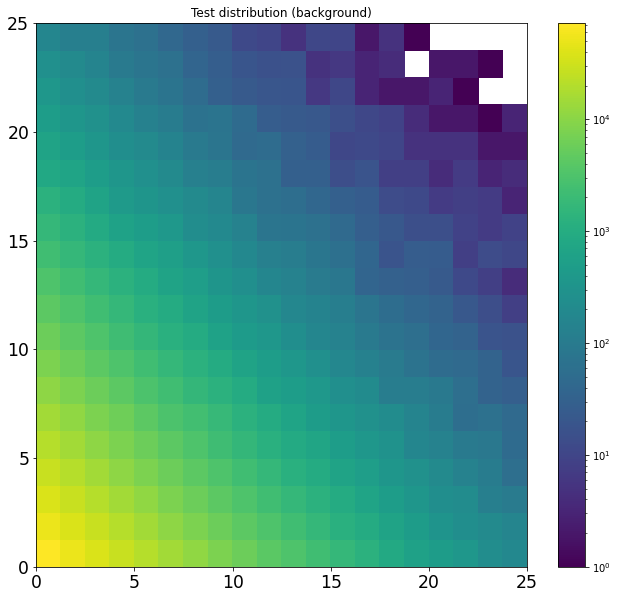

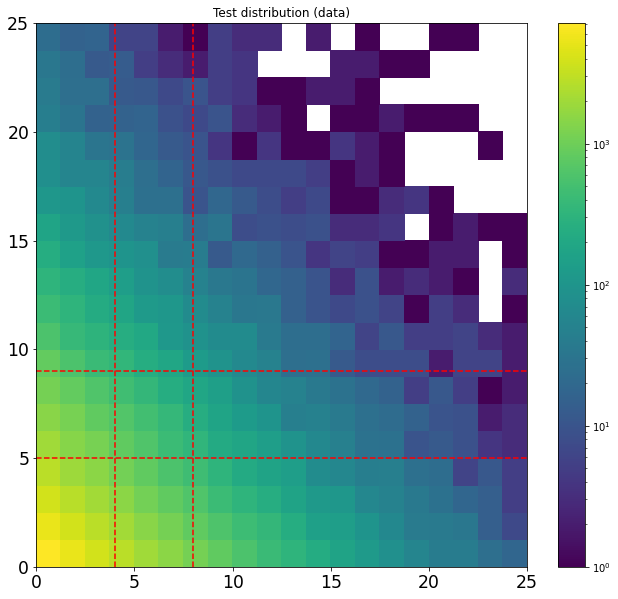

In [3]:
# Plot the 2 distributions (data and background) as 2D histograms
F = plt.figure(figsize=(11, 10))
plt.title("Test distribution (background)")
_, binx, biny, _ = plt.hist2d(
    bkg[:, 0], bkg[:, 1], bins=[20, 20], range=rang, norm=matplotlib.colors.LogNorm()
)
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.colorbar()
plt.show()

# The red dashed lines show the true posision of the signal
F = plt.figure(figsize=(11, 10))
plt.title("Test distribution (data)")
plt.hist2d(
    data[:, 0], data[:, 1], bins=[20, 20], range=rang, norm=matplotlib.colors.LogNorm()
)
plt.hlines([5.0, 9.0], binx[0], binx[-1], linestyles="dashed", color="r")
plt.vlines([4.0, 8.0], biny[0], biny[-1], linestyles="dashed", color="r")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.colorbar()
plt.show()

## Create a DataHandler class instance

The DataHandler class take care of managing histograms.

It can handle histograms with 1 or 2 dimension for multiple channels.

In [4]:
dh = BH.DataHandler(ndim=2, nchan=1)
dh.set_ref(
    bkg,
    bins=[[20, 20]],
    rang=rang,
    weights=np.full(bkg.shape[0], 0.1) # Use event weights to normalize the background to data
)
dh.set_data(data)
dh.set_sig(sig, signal_exp=Nsig)  # Set the expected number of signal event here

## Create a BumpHunter2D class instance.

The BumpHunter2D class provides all the methods required extend the bump hunt to 2D distributions.

All the parameters and results are also stored in this object.

In [5]:
# Create a BumpHunter2D class instance
hunter = BH.BumpHunter2D(
    width_min=[2, 2],
    width_max=[3, 3],
    width_step=[1, 1],
    scan_step=[1, 1],
    npe=10_000,
    nworker=1,
    seed=666,
)

## Call the bump_scan Method

The function will scan the data distribution using variable-width window sizes (between width_min and width_max) and calculate the p-value of data with respect to the background for each window. The minimum p-value obtained from all windows is the local p-value.

To cope with the look-elsewhere effect a global p-value is calculated using a two-step procedure:
- the distribution of possible p-values is determined from background-only pseudo-experiments (npe parameter)
- the p-value found in data is compared to the background-only p-value distribution to calculate the global p-value

In [6]:
print("####bump_scan call####")
begin = datetime.now()
hunter.bump_scan(dh)
end = datetime.now()
print(f"time={end - begin}")

####bump_scan call####
Generating 10000 background-only histograms
4 values of width will be tested
SCAN CH0
####CH0
Global p-value : 0.00000  (0 / 10000)
Significance > 3.71902 (lower limit)
Fit is required !
Global p-value (fit) = 0.00013
significnce (fit) = 3.65590

time=0:02:04.035834


## Print results of BH scan

Print information on more significant window ("bump"): location, width, excess over background events, global p-value and global significance.

In [7]:
print(hunter.bump_info(dh))
print(f"   mean (true) = {Lth}")

####BUMP SCAN SUMMARY####
Channel 0 :
    Bump x edges : [3.75, 7.5] (loc=3, width=3)
    Bump mean x | width x : 5.62 | 3.75
    Bump y edges : [6.25, 10] (loc=5, width=3)
    Bump mean y | width y : 8.12 | 3.75
    Number of signal events : 290
    Local p-value | test statistic : 1.0699e-07 | 16.05
    Local significance : 5.1868
    global p-value : 0
    global significance > 3.719 (lower limit)
    Fit parameters :
        pM = 0.3271 +- 0.0090004
        m = 119.3 +- 7.8915
        A = 2487 +- 24.937
    Fit p-value : 0.00012814
    Fit significance : 3.6559

   mean (true) = [6.0, 7.0]


## Show most significant window

Window with the lowest p-value obtained from the data scans.

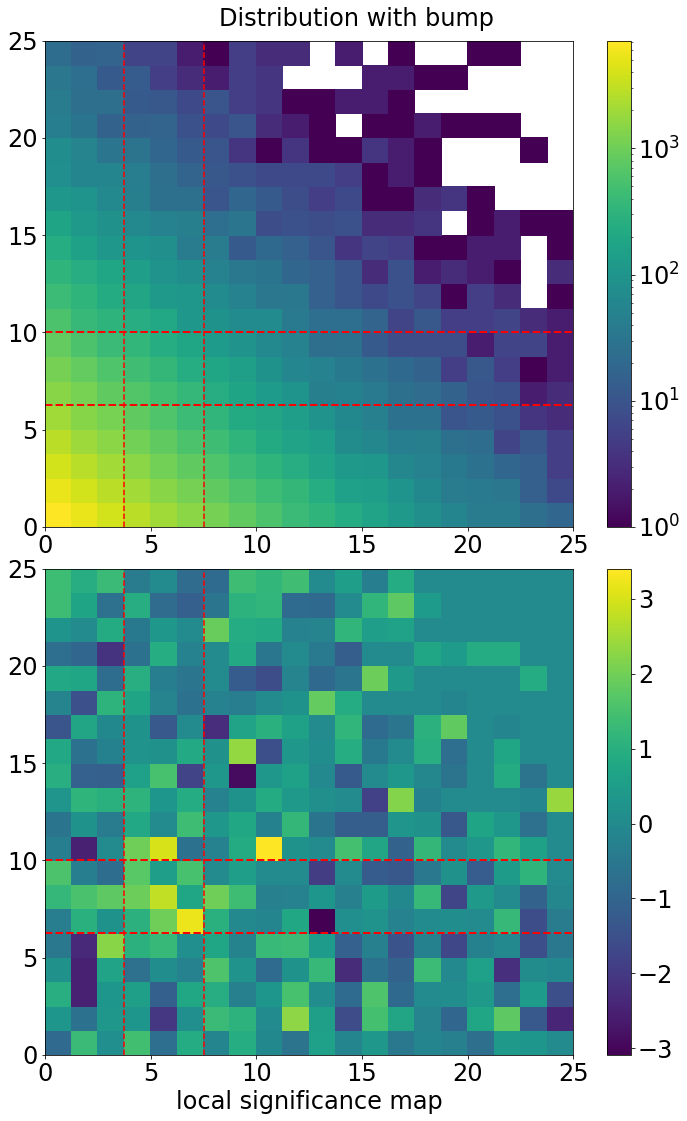

In [8]:
# Get and save bump plot
F = plt.figure(figsize=(10, 15))
plt.suptitle("Distribution with bump", size=24)
pl = hunter.plot_bump(dh, fontsize=24)
pl[1].axes.set_xlabel("local significance map", size=24)
plt.show()

# Global p-value

This figure shows the test statistics (-log(p-value)) obtained from background-only toys and the p-value obtained from data. The global p-value is equal to the fraction of background-only experiments whch have a higher test statistics than for the data (i.e this is the p-value of p-values).

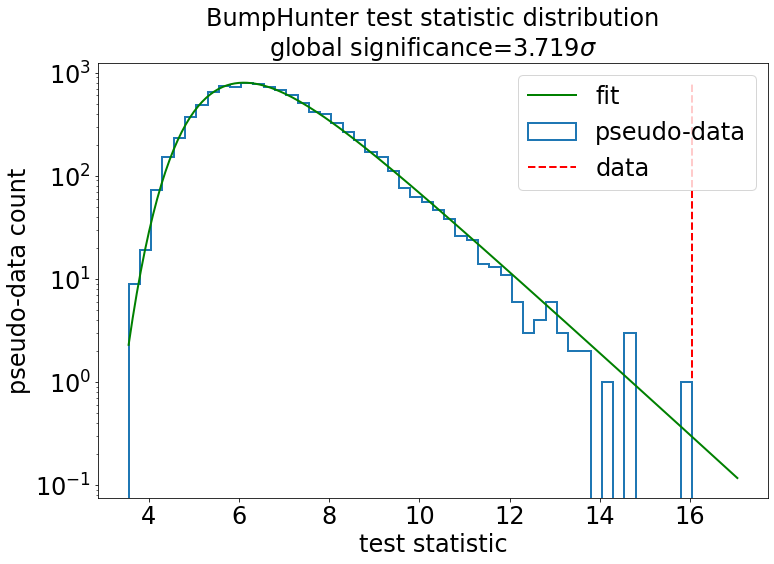

In [9]:
# Get and save statistics plot
F = plt.figure(figsize=(12, 8))
plt.title(f"BumpHunter test statistic distribution\nglobal significance={hunter.significance[0]:.3f}$\sigma$", size=24)
hunter.plot_stat()
plt.legend(fontsize=24)
plt.xlabel("test statistic", size=24)
plt.ylabel("pseudo-data count", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

## Signal injection

Inject signal in data until a 5 sigma excess is found. 

In [10]:
# We have to set additionnal parameters specific to the signal injection.
# All the parameters defined previously are kept.
hunter.sigma_limit = 5
hunter.str_min = -1  # if str_scale='log', the real starting value is 10**str_min
hunter.str_scale = "log"
hunter.npe_inject = 1000

print("####singal_inject call####")
begin = datetime.now()
hunter.signal_inject(dh, do_pseudo=False) # We don't need to scan bkg-only pseudo-data again
end = datetime.now()
print(f"time={end - begin}")

####singal_inject call####
4 values of width will be tested
STARTING INJECTION
   STEP 1 : signal strength = 0.1
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.46880  (4688 / 10000)   0.70600  (7060)   0.23310  (2331)
Significance = 0.078287 (-0.54174  0.72868)

   STEP 2 : signal strength = 0.2
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.34460  (3446 / 10000)   0.63620  (6362)   0.16340  (1634)
Significance = 0.39994 (-0.34832  0.98058)

   STEP 3 : signal strength = 0.30000000000000004
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.27190  (2719 / 10000)   0.49520  (4952)   0.08700  (870)
Significance = 0.60708 (0.012032  1.3595)

   STEP 4 : signal strength = 0.4
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.13440  (1344 / 10000)   0.33800  (3380)   0.02160  (216)
Significanc

## Plot injection results

Show the evolution of the global significance with the signal strength.

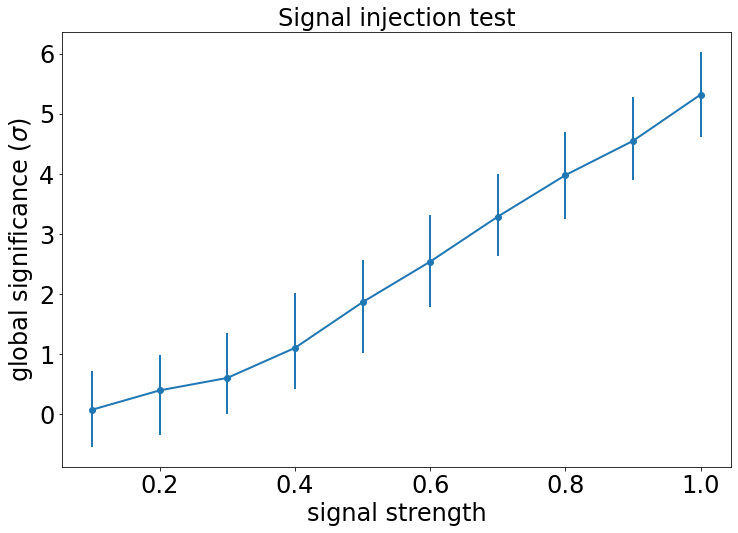

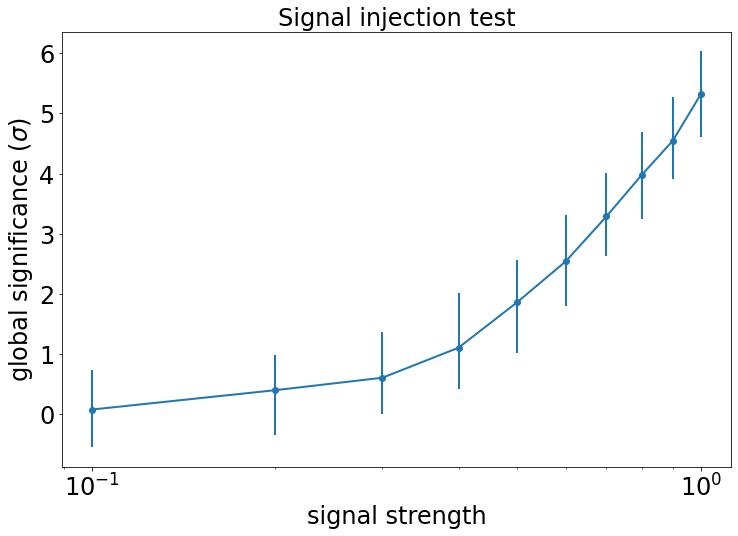

In [11]:
# Get and save the injection plot
F = plt.figure(figsize=(12,8))
plt.title("Signal injection test", size=24)
hunter.plot_inject()
plt.xlabel("signal strength", size=24)
plt.ylabel("global significance ($\sigma$)", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

F = plt.figure(figsize=(12,8))
plt.title("Signal injection test", size=24)
hunter.plot_inject(log=True)
plt.xlabel("signal strength", size=24)
plt.ylabel("global significance ($\sigma$)", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

## Test statistic distributions

Show the test statistic distribution of the bkg-only and bkg+sig cases.

Note the fit of the bkg-only distribution.

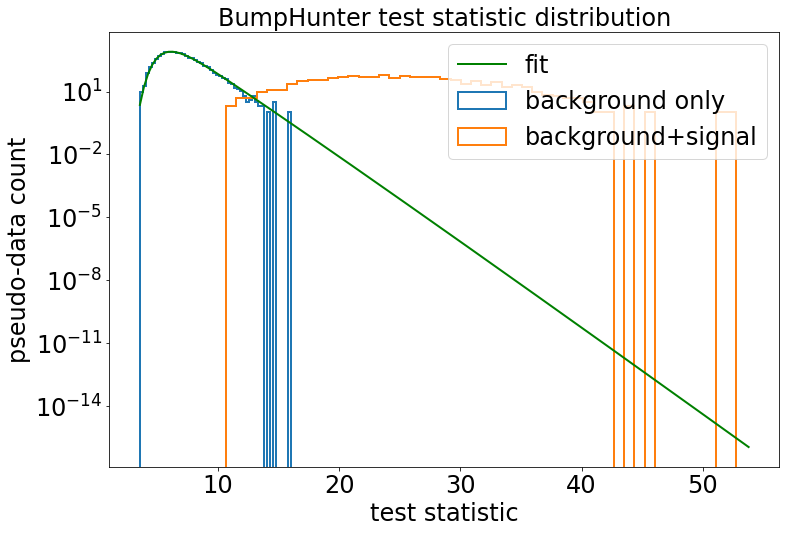

In [12]:
F = plt.figure(figsize=(12, 8))
plt.title("BumpHunter test statistic distribution", size=24)
hunter.plot_stat()
plt.legend(fontsize=24)
plt.xlabel("test statistic", size=24)
plt.ylabel("pseudo-data count", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()